<a href="https://colab.research.google.com/github/mrch-hub/bangkit1/blob/master/SolarPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Solar radiation intensity prediction using TensorFlow

In [0]:
"""A python code for predicting solar radiation
intensity using TensorFlow. Created for 
5th Bangk!t assignment.
Collaborators: Marcellinus Chrisnada, Muhammad
Harits Hafidza, Mochammad Randy Caesario H."""

'A python code for predicting solar radiation\nintensity using machine learning. Created for \n5th bangk!t assignment.\nCollaborators: Marcellinus Chrisnada, Muhammad\nHarits Hafidza, Mochammad Randy Caesario H.'

##Initialization and Data Preconditioning

In [0]:
#@title Run on TensorFlow 2.x
%tensorflow_version 2.x
from __future__ import absolute_import, division, print_function, unicode_literals

In [3]:
#@title Import relevant modules
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from matplotlib import pyplot as plt
import seaborn as sns

# Adjust the granularity of reporting. 
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

print("Imported modules.")

ERROR! Session/line number was not unique in database. History logging moved to new session 59
Imported modules.


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
#@title Load dataset
data = pd.read_csv('https://raw.githubusercontent.com/mrch-hub/bangkit1/master/SolarPrediction.csv')
data = data.reindex(np.random.permutation(data.index)) # shuffle dataset
data.head(40)

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
22703,1478541303,11/7/2016 12:00:00 AM,07:55:03,330.8,55,30.5,16,275.4,4.5,06:27:00,17:46:00
10661,1477018220,10/20/2016 12:00:00 AM,16:50:20,226.7,52,30.4,85,34.8,4.5,06:19:00,17:56:00
31561,1480923633,12/4/2016 12:00:00 AM,21:40:33,1.2,45,30.4,93,51.3,3.4,06:43:00,17:43:00
3258,1474226706,9/18/2016 12:00:00 AM,09:25:06,748.5,63,30.5,58,58.7,6.8,06:11:00,18:23:00
13669,1476103524,10/10/2016 12:00:00 AM,02:45:24,1.3,49,30.4,81,199.6,9.0,06:16:00,18:03:00
...,...,...,...,...,...,...,...,...,...,...,...
20568,1479181801,11/14/2016 12:00:00 AM,17:50:01,1.9,51,30.4,100,128.5,2.2,06:31:00,17:43:00
7107,1472829906,9/2/2016 12:00:00 AM,05:25:06,2.5,47,30.4,72,148.8,5.6,06:07:00,18:37:00
15227,1475625618,10/4/2016 12:00:00 AM,14:00:18,171.7,55,30.4,102,45.3,4.5,06:14:00,18:08:00
9279,1477434318,10/25/2016 12:00:00 AM,12:25:18,956.1,64,30.5,63,3.1,2.2,06:21:00,17:52:00


In [7]:
#@title Splitting data to train set and test set
test_split = 0.2 # percentage of train set to be considered as test set
data_test = data[:][0:round((len(data)*test_split))]
data_train = data[:][round((len(data)*test_split)):]
print('train set length:', str(len(data_train)), '\ntest set length:', 
      str(len(data_test)))

train set length: 26149 
test set length: 6537


In [8]:
#@title Normalize values 

# Calculate the Z-scores of each column in the training set:
data_train_mean = data_train[['UNIXTime', 'Radiation', 'Temperature', 'Pressure', 
                              'Humidity', 'WindDirection(Degrees)', 'Speed']].mean()
data_train_std = data_train[['UNIXTime', 'Radiation', 'Temperature', 'Pressure', 
                             'Humidity', 'WindDirection(Degrees)', 'Speed']].std()
data_train_norm = (data_train[['UNIXTime', 'Radiation', 'Temperature', 'Pressure', 
                               'Humidity', 'WindDirection(Degrees)', 'Speed']] 
                   - data_train_mean)/data_train_std

# Calculate the Z-scores of each column in the test set.
data_test_mean = data_test[['UNIXTime', 'Radiation', 'Temperature', 'Pressure', 
                            'Humidity', 'WindDirection(Degrees)', 'Speed']].mean()
data_test_std = data_test[['UNIXTime', 'Radiation', 'Temperature', 'Pressure', 
                           'Humidity', 'WindDirection(Degrees)', 'Speed']].std()
data_test_norm = (data_test[['UNIXTime', 'Radiation', 'Temperature', 'Pressure', 
                             'Humidity', 'WindDirection(Degrees)', 'Speed']] 
                  - data_test_mean)/data_test_std

print("Normalized the values.")
data_train_norm.describe()

Normalized the values.


,UNIXTime,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed
count,26149.0,26149.0,26149.0,26149.0,26149.0,26149.0,26149.0
mean,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0
std,1.0,1.0,1.0,1.0,1.0,1.0,1.0
min,-1.8,-0.7,-2.6,-4.3,-2.5,-1.7,-1.8
25%,-0.8,-0.7,-0.8,-0.4,-0.7,-0.7,-0.8
50%,-0.0,-0.6,-0.2,0.1,0.4,0.0,-0.2
75%,0.8,0.5,0.6,0.7,0.8,0.4,0.5
max,1.7,4.0,3.2,2.5,1.1,2.6,9.8


## Represent data

The following code cell creates a feature layer containing two features:

* `Temperature`
* `Pressure`

In [0]:
# Create empty feature column list
feature_columns = []

# Represent temperature as a floating-point value.
temperature = tf.feature_column.numeric_column("Temperature")
feature_columns.append(temperature)

# Represent pressure as a floating-point value.
pressure = tf.feature_column.numeric_column("Pressure")
feature_columns.append(pressure)

# Convert the list of feature columns into a layer that will later be fed into
# the model. 
my_feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

## Build a linear regression model

In [10]:
#@title Define plotting function

def plot_the_loss_curve(epochs, mse):
  """Plot a curve of loss vs. epoch."""

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Mean Squared Error")

  plt.plot(epochs, mse, label="Loss")
  plt.legend()
  plt.ylim([mse.min()*0.95, mse.max() * 1.03])
  plt.show()  

print("Defined the plot_the_loss_curve function.")

Defined the plot_the_loss_curve function.


In [11]:
#@title Define functions to create and train a linear regression model
def create_model(my_learning_rate, feature_layer):
  """Create and compile a simple linear regression model."""
  # Most simple tf.keras models are sequential.
  model = tf.keras.models.Sequential()

  # Add the layer containing the feature columns to the model.
  model.add(feature_layer)

  # Add one linear layer to the model to yield a simple linear regressor.
  model.add(tf.keras.layers.Dense(units=1, input_shape=(1,)))

  # Construct the layers into a model that TensorFlow can execute.
  model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=my_learning_rate),
                loss="mean_squared_error",
                metrics=[tf.keras.metrics.MeanSquaredError()])

  return model           


def train_model(model, dataset, epochs, batch_size, label_name):
  """Feed a dataset into the model in order to train it."""

  # Split the dataset into features and label.
  features = {name:np.array(value) for name, value in dataset.items()}
  label = np.array(features.pop(label_name))
  history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=True)

  # Get details that will be useful for plotting the loss curve.
  epochs = history.epoch
  hist = pd.DataFrame(history.history)
  rmse = hist["mean_squared_error"]

  return epochs, rmse   

print("Defined the create_model and train_model functions.")

Defined the create_model and train_model functions.


Epoch 1/50
27/27 [==============================] - 0s 2ms/step - loss: 0.4977 - mean_squared_error: 0.5009
Epoch 2/50
27/27 [==============================] - 0s 1ms/step - loss: 0.4495 - mean_squared_error: 0.4499
Epoch 3/50
27/27 [==============================] - 0s 1ms/step - loss: 0.4480 - mean_squared_error: 0.4469
Epoch 4/50
27/27 [==============================] - 0s 1ms/step - loss: 0.4481 - mean_squared_error: 0.4472
Epoch 5/50
27/27 [==============================] - 0s 1ms/step - loss: 0.4447 - mean_squared_error: 0.4472
Epoch 6/50
27/27 [==============================] - 0s 1ms/step - loss: 0.4470 - mean_squared_error: 0.4473
Epoch 7/50
27/27 [==============================] - 0s 1ms/step - loss: 0.4501 - mean_squared_error: 0.4471
Epoch 8/50
27/27 [==============================] - 0s 2ms/step - loss: 0.4448 - mean_squared_error: 0.4473
Epoch 9/50
27/27 [==============================] - 0s 1ms/step - loss: 0.4513 - mean_squared_error: 0.4473
Epoch 10/50
27/27 [=========

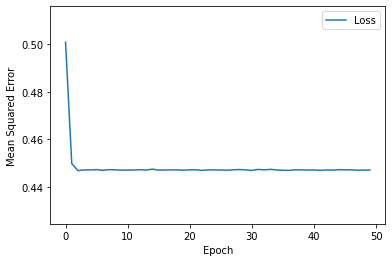


 Evaluate the linear regression model against the test set:
7/7 [==============================] - 0s 1ms/step - loss: 0.4502 - mean_squared_error: 0.4463


[0.45016786456108093, 0.44629010558128357]

In [14]:
#@title Train the model as linear regression
# The following variables are the hyperparameters.
learning_rate = 0.01
epochs = 50
batch_size = 1000
label_name = "Radiation"

# Establish the model's topography.
my_model = create_model(learning_rate, my_feature_layer)

# Train the model on the normalized training set.
epochs, mse = train_model(my_model, data_train_norm, epochs, batch_size, label_name)
plot_the_loss_curve(epochs, mse)

test_features = {name:np.array(value) for name, value in data_test_norm.items()}
test_label = np.array(test_features.pop(label_name)) # isolate the label
print("\n Evaluate the linear regression model against the test set:")
my_model.evaluate(x = test_features, y = test_label, batch_size=batch_size)